# Library Packages

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2023-02-18 22:30:47.930079: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-18 22:31:26.375555: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 22:31:26.429744: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-18 22:31:26.602910: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-18 22:31:31.607616: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-18 22:31:31.607653: I tensorflow/stream_executo

In [2]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import initializers

# Model
from lightgbm import LGBMRegressor

# Hyperparams Search
from sklearn.model_selection import cross_val_score
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# Load Normalized Data

This data have been cleaned, and normalized with
* LabelEncoders - for categorical variables
* StandardScaler - for continuous variables

In [4]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')
df.drop('index',axis='columns',inplace=True)

Columns in each dataset

In [5]:
set(df.columns.tolist())-set(df_test.columns.tolist())

{'Customers', 'Sales'}

# Data Analysis
Check some correlations between columns that will give us information about how to build the NN

In [6]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'Cl

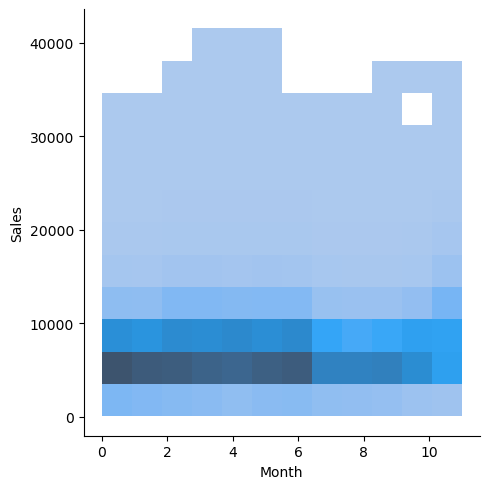

In [10]:
sns.displot(y=df.Sales,x=df.Month,bins=12)

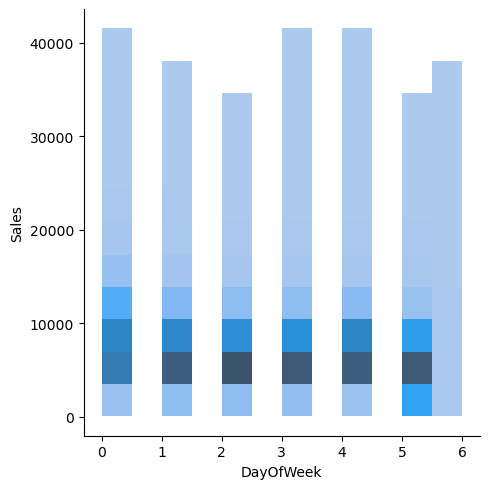

In [11]:
sns.displot(y=df.Sales,x=df.DayOfWeek,bins=12)

In [92]:
cat_vars = ['Store','Year','Month','StateHoliday','CompetitionMonthsOpen',
    'Promo2Weeks','StoreType','Assortment','PromoInterval',
    'CompetitionOpenSinceYear','State',
    'Week','Events','Promo_fw','Promo_bw','StateHoliday_bool_fw', 'StateHoliday_bool_bw','SchoolHoliday_fw','SchoolHoliday_bw']#'DayOfWeek'

contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 
 'CloudCover', 'trend',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']

In [93]:
corr_df_cat = df[cat_vars+['Sales']].corr().loc['Sales'].apply(lambda x: np.abs(x)).drop(['Sales'])
corr_df_con = df[contin_vars+['Sales']].corr().loc['Sales'].apply(lambda x: np.abs(x)).drop(['Sales'])

corr_factor = 0.03
display("CAT ",len(corr_df_cat[corr_df_cat>corr_factor]),":",corr_df_cat[corr_df_cat>corr_factor].index.to_list())
display("CON ",len(corr_df_con[corr_df_con>corr_factor]),":",corr_df_con[corr_df_con>corr_factor].index.to_list())

'CAT '

11

':'

['Year',
 'Month',
 'CompetitionMonthsOpen',
 'Promo2Weeks',
 'Assortment',
 'PromoInterval',
 'State',
 'Week',
 'Promo_fw',
 'Promo_bw',
 'StateHoliday_bool_fw']

'CON '

4

':'

['CompetitionDistance', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday']

In [172]:
cat_vars = corr_df_cat[corr_df_cat>corr_factor].index.to_list()
contin_vars = corr_df_con[corr_df_con>corr_factor].index.to_list()
len(cat_vars),len(contin_vars)

# Empiric result

cat_vars = ['Store', 'DayOfWeek', 'Promo_bw', 'Month', 'Year', 'State', 'Assortment', 'StoreType', 'Events', 'StateHoliday', 'Promo2SinceYear']
contin_vars = [ 'Max_TemperatureC', 'Precipitationmm', 'Promo', 'SchoolHoliday', 'trend', 'Mean_TemperatureC','CompetitionDistance']

In [173]:
df[cat_vars+contin_vars].corr()

,Store,DayOfWeek,Promo_bw,Month,Year,State,Assortment,StoreType,Events,StateHoliday,Promo2SinceYear,Max_TemperatureC,Precipitationmm,Promo,SchoolHoliday,trend,Mean_TemperatureC,CompetitionDistance
Store,1.000000,0.000343,0.000219,0.001371,0.000300,0.021937,0.005733,-0.021149,0.001603,0.002043,0.020989,-0.000865,0.003708,-0.000015,0.000526,0.006547,0.000649,-0.023337
DayOfWeek,0.000343,1.000000,0.004746,-0.019710,0.002099,-0.001956,0.001215,-0.001974,-0.027584,-0.002699,-0.001493,0.009737,-0.003322,-0.289268,-0.139319,0.000876,0.007962,0.004893
Promo_bw,0.000219,0.004746,1.000000,0.016442,0.025769,0.004290,0.000742,-0.001004,0.061150,0.006137,-0.002546,0.028092,0.019999,0.309416,-0.063546,-0.191277,0.026783,0.000687
Month,0.001371,-0.019710,0.016442,1.000000,-0.268835,0.033331,0.008352,-0.007643,-0.133169,0.005277,-0.024511,0.291897,0.033083,-0.006412,0.118467,0.289025,0.342007,0.002604
Year,0.000300,0.002099,0.025769,-0.268835,1.000000,0.006333,0.002034,-0.001492,0.018925,0.000934,-0.005238,0.064106,0.007879,0.023990,-0.038686,0.358381,0.035455,0.000396
State,0.021937,-0.001956,0.004290,0.033331,0.006333,1.000000,0.113563,-0.044941,0.059103,-0.000019,-0.027793,-0.007882,0.039157,0.003574,0.005815,-0.055484,0.011104,0.257695
Assortment,0.005733,0.001215,0.000742,0.008352,0.002034,0.113563,1.000000,0.230834,0.004358,-0.000626,0.028775,-0.001715,0.002476,-0.000333,-0.002714,-0.009576,-0.000030,0.131580
StoreType,-0.021149,-0.001974,-0.001004,-0.007643,-0.001492,-0.044941,0.230834,1.000000,0.010482,-0.004435,0.049945,0.005308,-0.010235,0.000324,-0.002263,-0.031700,-0.000206,0.079155
Events,0.001603,-0.027584,0.061150,-0.133169,0.018925,0.059103,0.004358,0.010482,1.000000,-0.000796,-0.015901,0.009385,-0.033377,-0.000179,0.034472,-0.023891,0.022518,0.027613
StateHoliday,0.002043,-0.002699,0.006137,0.005277,0.000934,-0.000019,-0.000626,-0.004435,-0.000796,1.000000,-0.006138,-0.003324,0.005455,-0.002418,0.022889,-0.003800,-0.002508,0.006425


In [130]:
DataFrameSummary(df[cat_vars+contin_vars]).summary().loc[['uniques', 'types', 'missing']]

,Store,DayOfWeek,Promo_bw,Day,Month,Year,State,Assortment,StoreType,Events,StateHoliday,Promo2SinceYear,Max_TemperatureC,Precipitationmm,Promo,SchoolHoliday,Max_Wind_SpeedKm_h,trend,Mean_TemperatureC
uniques,1115,7,6,31,12,3,12,3,4,22,4,8,50,39,2,2,42,67,45
types,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,bool,bool,numeric,numeric,numeric
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [131]:
DataFrameSummary(df[cat_vars+contin_vars]).summary().loc[['uniques', 'types', 'missing']].T.groupby('types').max()

,uniques,missing
types,,
bool,2,0
numeric,1115,0


# Data Model

In [174]:
# cat_vars = ['Store','DayOfWeek','Year','Month','Day','StateHoliday','CompetitionMonthsOpen',
#     'Promo2Weeks','StoreType','Assortment','PromoInterval',
#     'CompetitionOpenSinceYear','Promo2SinceYear','State',
#     'Week','Events','Promo_fw','Promo_bw','StateHoliday_bool_fw', 'StateHoliday_bool_bw','SchoolHoliday_fw','SchoolHoliday_bw']

# cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
#             'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
#             'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

len(cat_vars)

11

In [175]:
# contin_vars = ['CompetitionDistance', 
#    'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
#    'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
#    'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
#    'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']
len(contin_vars)

7

In [134]:
# cat_vars = ['Store', 'DayOfWeek', 'Promo_bw', 'Day', 'Month', 'Year', 'State', 'Assortment', 'StoreType', 'Events', 'StateHoliday', 'Promo2SinceYear'] #, 'PromoInterval', 'Promo2Weeks']

# contin_vars = [ 'Max_TemperatureC', 'Precipitationmm', 'Promo', 'SchoolHoliday', 'Max_Wind_SpeedKm_h', 'trend', 'Mean_TemperatureC'] #, 'Max_Wind_SpeedKm_h'] #, 'CompetitionDistance'] #,'BeforeStateHoliday_bool']
len(cat_vars),len(contin_vars)

(12, 7)

In [135]:
# cat_vars = ['DayOfWeek','Assortment','PromoInterval','Promo2SinceYear','Promo_fw','StateHoliday_bool_fw']
# contin_vars = ['Promo']

In [136]:
# Check all columns on df are consistent with name of variables
# display(set(contin_vars+cat_vars))
# display(set(df.columns))
set(df.columns)-set(contin_vars+cat_vars)

{'AfterPromo',
 'AfterSchoolHoliday',
 'AfterStateHoliday_bool',
 'BeforePromo',
 'BeforeSchoolHoliday',
 'BeforeStateHoliday_bool',
 'CloudCover',
 'CompetitionDaysOpen',
 'CompetitionDistance',
 'CompetitionMonthsOpen',
 'CompetitionOpenSince',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Customers',
 'Date',
 'Date_DE',
 'Date_y',
 'Day_DE',
 'Day_y',
 'Dew_PointC',
 'Max_Gust_SpeedKm_h',
 'Max_Humidity',
 'Max_Sea_Level_PressurehPa',
 'Max_VisibilityKm',
 'MeanDew_PointC',
 'Mean_Humidity',
 'Mean_Sea_Level_PressurehPa',
 'Mean_VisibilityKm',
 'Mean_Wind_SpeedKm_h',
 'Min_DewpointC',
 'Min_Humidity',
 'Min_Sea_Level_PressurehPa',
 'Min_TemperatureC',
 'Min_VisibilitykM',
 'Month_DE',
 'Month_y',
 'Open',
 'Promo2',
 'Promo2Days',
 'Promo2Since',
 'Promo2SinceWeek',
 'Promo2Weeks',
 'PromoInterval',
 'Promo_fw',
 'Sales',
 'SchoolHoliday_bw',
 'SchoolHoliday_fw',
 'StateHoliday_bool',
 'StateHoliday_bool_bw',
 'StateHoliday_bool_fw',
 'StateName',
 'State_DE',
 'Week

In [137]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred)/y_true)**2))

In [138]:
def calculate_RMSE(X, y, model, log_output=True):
    y_preds = np.exp(model.predict(X, verbose=1)*max_log_y)
    return np.sqrt((((y - y_preds)/y)**2).sum()/len(y_preds))

### Split Data for Train and Validation

In [139]:
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

In [140]:
split_contins = False
def split_data():
    if split_contins:
        map_train = split_cols(cats_trn) + split_cols(contins_trn)
        map_valid = split_cols(cats_val) + split_cols(contins_val)
    else:
        map_train = cats_trn+contins_trn
        map_valid = cats_val+contins_val
    return map_train, map_valid

In [176]:
from sklearn.model_selection import TimeSeriesSplit
n=len(df.Sales)

train_ratio=0.9
train_size = int(n*train_ratio)
# contins_trn, contins_val = df[contin_vars].loc[:train_size-1], df[contin_vars].loc[train_size:]
# cats_trn, cats_val       = df[cat_var_dict.keys()].loc[:train_size-1], df[cat_var_dict.keys()].loc[train_size:]

X_train,X_valid                  = df[cat_vars+contin_vars].loc[:train_size-1], df[cat_vars+contin_vars].loc[train_size:]

max_y_log                        = (np.log(df.Sales)).values.max()
y_train, y_valid                 = np.log(df.Sales.loc[:train_size-1])/max_y_log, np.log(df.Sales.loc[train_size:])/max_y_log

print("X_train[",type(X_train),"]: ",X_train.shape,"      y_train[",type(y_train),"]: ",y_train.shape)
print("X_valid[",type(X_train),"]: ",X_valid.shape,"      y_valid[",type(y_valid),"]: ",y_valid.shape)

tscv = TimeSeriesSplit(n_splits=2, test_size=(n - train_size))
display('test_size: ',(n - train_size))

X_train[ <class 'pandas.core.frame.DataFrame'> ]:  (759904, 18)       y_train[ <class 'pandas.core.series.Series'> ]:  (759904,)
X_valid[ <class 'pandas.core.frame.DataFrame'> ]:  (84434, 18)       y_valid[ <class 'pandas.core.series.Series'> ]:  (84434,)


'test_size: '

84434

In [177]:
for train_index, test_index in tscv.split(df[cat_vars+contin_vars]):
    print("-----------")
    print(train_index)
    print(test_index)

-----------
[     0      1      2 ... 675467 675468 675469]
[675470 675471 675472 ... 759901 759902 759903]
-----------
[     0      1      2 ... 759901 759902 759903]
[759904 759905 759906 ... 844335 844336 844337]


In [163]:
df[cat_vars+contin_vars].shape

(844338, 17)

### Search Hyperparameters with GridSearch

In [178]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [179]:
parameters = {
    'min_child_samples' : [7],
    'n_estimators'      : [7000],
    'learning_rate'     : [0.01],
    'min_data_in_leaf'  : [500],   # setting it to hundreds or thousands is enough for a large dataset
    'max_depth'         : [7],     # max_depth=7 the depth-wise tree can get good accuracy
    'num_leaves'        : [70],    # we should let it be smaller than 2^(max_depth)
    'reg_alpha'         : [0.1],   # l1
}

grid_search_rmspe = make_scorer(rmspe,greater_is_better=False)
model = LGBMRegressor()

In [180]:
clf = GridSearchCV(model, parameters, n_jobs = 4, verbose=100, cv=tscv, scoring=grid_search_rmspe)

### Create Model

In [183]:
def train(model, X_train, X_valid):    
    fit_params={"early_stopping_rounds":100, 
                "eval_metric" : 'l2',
                "eval_set" : [(X_valid, y_valid)],
                'verbose': 100,
                'feature_name': 'auto',
                'categorical_feature': cat_vars
               }

    return model.fit(X_train, y_train, **fit_params)

### Train Model and Split Data

In [184]:
train(clf, X_train, X_valid)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/facu/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/facu/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'DayOfWeek', 'Events', 'Month', 'Promo2SinceYear', 'Promo_bw', 'State', 'StateHoliday', 'Store', 'StoreType', 'Year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/home/facu/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/facu/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'DayOfWeek', 'Events', 'Month', 'Promo2SinceYear', 'Promo_bw'

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=500


/home/facu/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/facu/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.000922636
[200]	valid_0's l2: 0.000687537
[300]	valid_0's l2: 0.000571059
[400]	valid_0's l2: 0.000503195
[500]	valid_0's l2: 0.000457982
[600]	valid_0's l2: 0.00042327
[700]	valid_0's l2: 0.000404624
[800]	valid_0's l2: 0.000388088
[900]	valid_0's l2: 0.000373186
[1000]	valid_0's l2: 0.00035838
[CV 2/2; 1/1] START learning_rate=0.01, max_depth=7, min_child_samples=7, min_data_in_leaf=500, n_estimators=7000, num_leaves=70, reg_alpha=0.1
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=500
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.000931643
[200]	valid_0's l2: 0.000696952
[300]	valid_0's l2: 0.000576972
[400]	valid_0's l2: 0.000508715
[500]	valid_0's l2: 0.000466797
[600]	valid_0's l2: 0.000435716
[700]	valid_0's l2: 0.000417298
[800]	valid_0's l2: 0.000397828
[900]	valid_0's l2: 0.000384178
[1

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=84434),
             estimator=LGBMRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01], 'max_depth': [7],
                         'min_child_samples': [7], 'min_data_in_leaf': [500],
                         'n_estimators': [7000], 'num_leaves': [70],
                         'reg_alpha': [0.1]},
             scoring=make_scorer(rmspe, greater_is_better=False), verbose=100)

# Submit Competition

In [185]:
X_test = df_test[cat_vars+contin_vars].loc[:train_size-1]

In [186]:
clf.best_params_

{'learning_rate': 0.01,
 'max_depth': 7,
 'min_child_samples': 7,
 'min_data_in_leaf': 500,
 'n_estimators': 7000,
 'num_leaves': 70,
 'reg_alpha': 0.1}

In [187]:
# y_pred = np.exp(clf.predict(X_valid)*max_y_log)[:,0]
# y_pred_test = np.exp(clf.predict(X_test)*max_y_log)[:,0]
y_pred = np.exp(clf.predict(X_valid)*max_y_log)
y_pred_test = np.exp(clf.predict(X_test)*max_y_log)
# display(y_pred_test.shape)

In [188]:
sample_csv = pd.read_csv('rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_lightGBM.csv', index=False)

[CV 1/2; 1/1] START learning_rate=0.01, max_depth=7, min_child_samples=7, min_data_in_leaf=500, n_estimators=7000, num_leaves=70, reg_alpha=0.1
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=500
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.000949199
[200]	valid_0's l2: 0.000712654
[300]	valid_0's l2: 0.000594339
[400]	valid_0's l2: 0.000524929
[500]	valid_0's l2: 0.000483029
[600]	valid_0's l2: 0.00045337
[700]	valid_0's l2: 0.000429542
[800]	valid_0's l2: 0.000414684
[900]	valid_0's l2: 0.000401164
[1000]	valid_0's l2: 0.000388664
[1100]	valid_0's l2: 0.00037757
[1200]	valid_0's l2: 0.000368467
[1300]	valid_0's l2: 0.000359517
[1400]	valid_0's l2: 0.000352489
[1500]	valid_0's l2: 0.000346365
[1600]	valid_0's l2: 0.000338968
[1700]	valid_0's l2: 0.000332578
[1800]	valid_0's l2: 0.000325633
[1900]	valid_0's l2: 0.000320109
[2000]	valid_0's l2: 0.000314619
[2100]	valid_0's l2: 0